In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
import pickle
import io
np.random.seed(1)

In [2]:
print("93")

93


In [3]:
context_length=5
prediction_length=5

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_uri = get_image_uri(boto3.Session().region_name, "forecasting-deepar")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [5]:
from sagemaker import get_execution_role
role = get_execution_role()

In [6]:
prefix = "bit-coin-forecast"

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = "bit-coin-data"

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [7]:
import os
def downloadDirectoryFroms3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName) 
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key)

In [8]:
downloadDirectoryFroms3("bit-coin-data", "bit-coin-forecast/data/output")

In [9]:
with open('bit-coin-forecast/data/output/epn.pkl', 'rb') as file:
    epn= pickle.load(file)

In [10]:
with open('bit-coin-forecast/data/output/ground_truth.pkl', 'rb') as file:
    time_series= pickle.load(file)

In [11]:
with open('bit-coin-forecast/data/output/train.pkl', 'rb') as file:
     time_series_training= pickle.load(file)

In [12]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [13]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"], content_type="application/json"):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(data=response_data["predictions"][k]["quantiles"], index=prediction_index)
            )
        return list_of_df

In [14]:
print(epn["epn"])

jumpstart-example-deepar-2022-09-27-14-16-44


In [15]:
predictor = DeepARPredictor(endpoint_name=epn["epn"], sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters("D", prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [16]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series[:5]

2015-12-02    402.901794
2015-12-03    500.902649
2015-12-04    524.908081
2015-12-05    510.335785
2015-12-06    582.979736
Freq: D, Name: 0.1, dtype: float64
2016-01-01    368.766998
2016-02-01    437.696991
2016-03-01    416.729004
2016-04-01    448.317993
2016-05-01    531.385986
dtype: float64


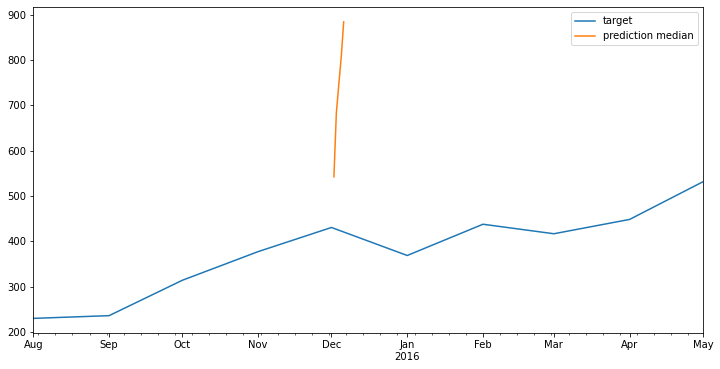

2016-01-02    450.817505
2016-01-03    526.151855
2016-01-04    552.757935
2016-01-05    600.659058
2016-01-06    589.963257
Freq: D, Name: 0.1, dtype: float64
2016-02-01    437.696991
2016-03-01    416.729004
2016-04-01    448.317993
2016-05-01    531.385986
2016-06-01    673.336975
dtype: float64


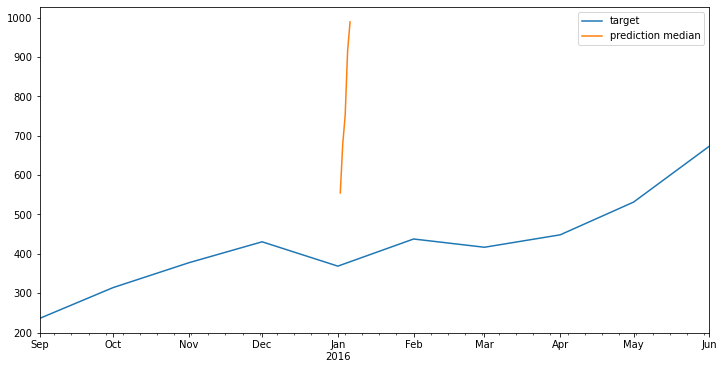

2016-02-02    436.075317
2016-02-03    509.240204
2016-02-04    584.101440
2016-02-05    693.823059
2016-02-06    604.226929
Freq: D, Name: 0.1, dtype: float64
2016-03-01    416.729004
2016-04-01    448.317993
2016-05-01    531.385986
2016-06-01    673.336975
2016-07-01    624.681030
dtype: float64


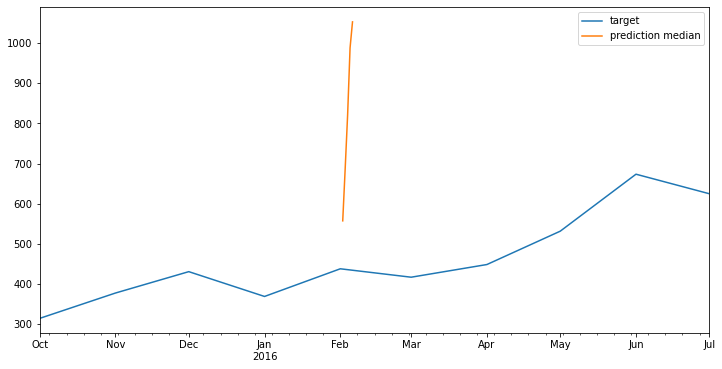

2016-03-02    451.141296
2016-03-03    495.381348
2016-03-04    581.803101
2016-03-05    639.171143
2016-03-06    675.894775
Freq: D, Name: 0.1, dtype: float64
2016-04-01    448.317993
2016-05-01    531.385986
2016-06-01    673.336975
2016-07-01    624.681030
2016-08-01    575.471985
dtype: float64


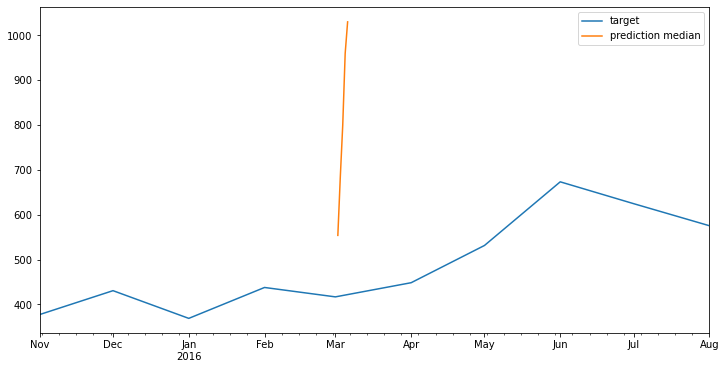

2016-04-02    446.796387
2016-04-03    559.362915
2016-04-04    558.077759
2016-04-05    648.569458
2016-04-06    700.314209
Freq: D, Name: 0.1, dtype: float64
2016-05-01    531.385986
2016-06-01    673.336975
2016-07-01    624.681030
2016-08-01    575.471985
2016-09-01    609.734985
dtype: float64


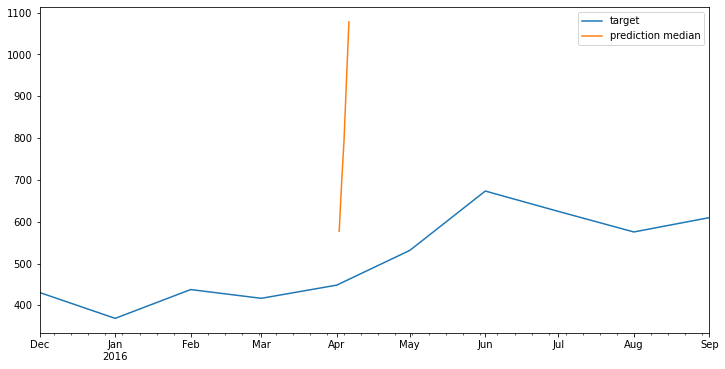

287.73863051226


In [17]:
sm=0
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    mn=(p10+p90)/2
    print(p10)
    print(actual_data[k][-prediction_length:])
    sm+=abs(actual_data[k][-prediction_length:].mean()-(p10.mean()+p90.mean())/2)
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()
print(sm/len(list_of_df))

In [18]:
dic={"res":sm/len(list_of_df)}
jres=json.dumps(dic)

In [19]:
encoding = "utf-8"
with open("eval.json", "wb") as f:
        f.write(jres.encode(encoding))


In [20]:
s3 = boto3.client("s3")

In [21]:
s3.upload_file("eval.json", bucket,  "eval.json")

In [22]:
sagemaker_session.delete_endpoint(epn["epn"])